In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *



     |████████████████████████████████| 720 kB 5.1 MB/s 
     |████████████████████████████████| 48 kB 4.3 MB/s 
     |████████████████████████████████| 1.2 MB 42.1 MB/s 
     |████████████████████████████████| 189 kB 53.0 MB/s 
     |████████████████████████████████| 55 kB 3.4 MB/s 
     |████████████████████████████████| 558 kB 45.7 MB/s 
     |████████████████████████████████| 51 kB 279 kB/s 
     |████████████████████████████████| 130 kB 54.2 MB/s 
Mounted at /content/gdrive


#Importación de las imágenes

En este proyecto vamos a entrenar redes neuronales para identificar 3 tipos de señal de tráfico distintas. Cartel de STOP, Ceda el paso y, prohibido el paso

In [ ]:
??search_images_ddg

In [ ]:
traffic_signs = 'no entry traffic sign', 'give way traffic sign', 'stop traffic sign'
path = Path('signs')

if not path.exists():
  path.mkdir()
  for o in traffic_signs:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(o, max_images=50)
    for i in range(1,51):
      try:
        download_url(results[i], f'{dest}/{i}.jpg')
      except:
        pass

In [ ]:
#shutil.rmtree('signs')

In [ ]:
fns = get_image_files(path)
fns

(#146) [Path('signs/no entry traffic sign/31.jpg'),Path('signs/no entry traffic sign/12.jpg'),Path('signs/no entry traffic sign/28.jpg'),Path('signs/no entry traffic sign/41.jpg'),Path('signs/no entry traffic sign/21.jpg'),Path('signs/no entry traffic sign/48.jpg'),Path('signs/no entry traffic sign/23.jpg'),Path('signs/no entry traffic sign/47.jpg'),Path('signs/no entry traffic sign/1.jpg'),Path('signs/no entry traffic sign/16.jpg')...]

Comprobación de imágenes corruptas y posterior eliminación

In [ ]:
failed = verify_images(fns)
failed

(#2) [Path('signs/stop traffic sign/47.jpg'),Path('signs/stop traffic sign/37.jpg')]

In [ ]:
failed.map(Path.unlink);

In [ ]:
traffic_signs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = traffic_signs.dataloaders(path)

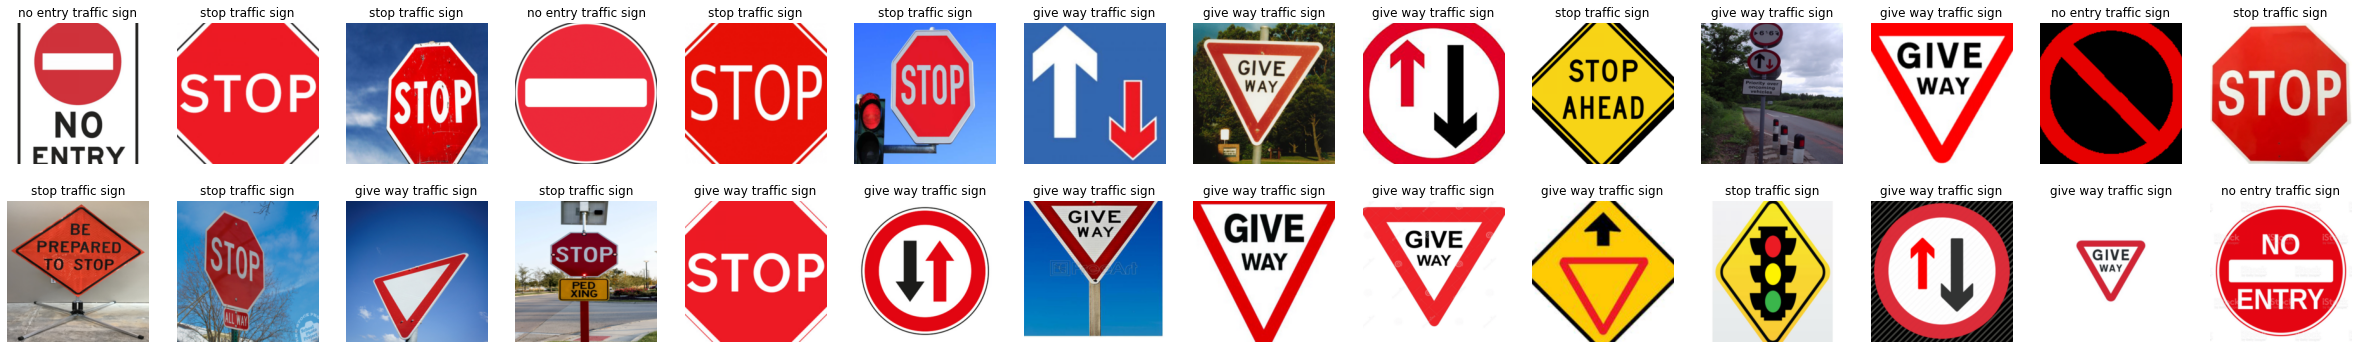

In [ ]:
dls.valid.show_batch(max_n=40, nrows=2)

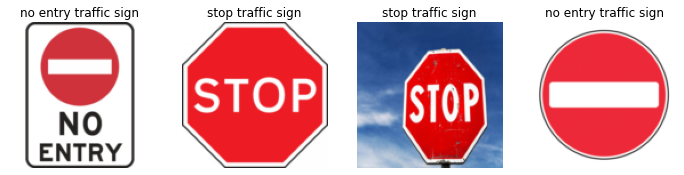

In [ ]:
traffic_signs = traffic_signs.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = traffic_signs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
traffic_signs = traffic_signs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = traffic_signs.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


Primer entrenamiento

In [ ]:
??learn.fine_tune()

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

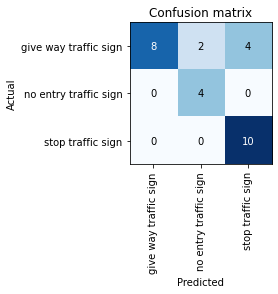

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

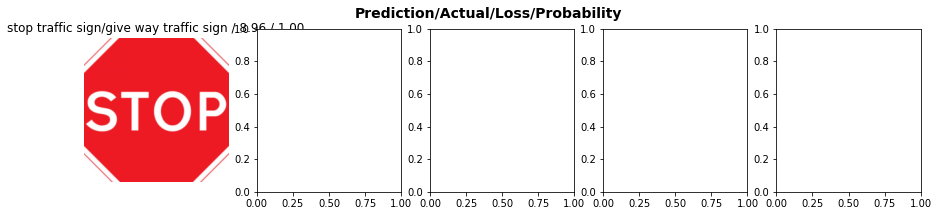

In [ ]:
interp.plot_top_losses(5, nrows=1)

Limpieza del dataset

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [ ]:
#for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Reentrenar el modelo

In [ ]:
traffic_signs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = traffic_signs.dataloaders(path)

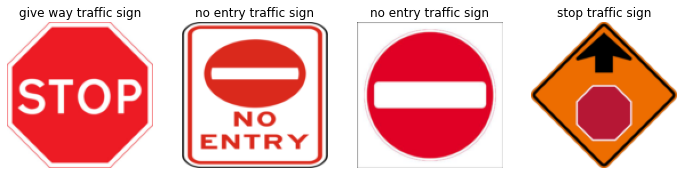

In [ ]:
traffic_signs = traffic_signs.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = traffic_signs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
traffic_signs = traffic_signs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = traffic_signs.dataloaders(path)

Reentrenamiento

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

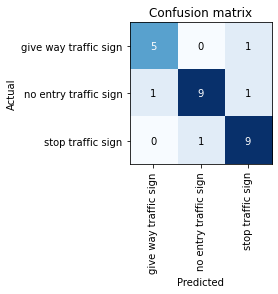

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Exportación del modelo

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('signs/give way traffic sign/35.jpg')

('give way traffic sign',
 TensorBase(0),
 TensorBase([9.9873e-01, 9.9466e-04, 2.7469e-04]))

In [ ]:
learn_inf.dls.vocab

['give way traffic sign', 'no entry traffic sign', 'stop traffic sign']